# Signal Processing

In [1]:
import librosa
import librosa.display
import os
import numpy as np
import IPython.display as ipd
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors import KNeighborsClassifier

## Loading Dataset
The dataset is loaded in one big dictionary with labels as keys i.e. to get number 1 from the signals dict, you need to call `signals[1]`.
All of the signals are resampled to `16000 kHz`.

In [2]:
sampling_rate = 16000
labels = list(range(1, 11))
cwd = os.getcwd() + '\\output_dataset\\'
signals = dict()

In [3]:
for label in labels:
    directory = cwd + str(label)
    for filename in os.listdir(directory):
        if filename.endswith(".wav"):
            if label not in signals.keys():
                signals[label] = []
            signals[label].append(librosa.load(os.path.join(directory, filename), sr=sampling_rate))
            
        else:
            continue

In [4]:
ipd.Audio(signals[1][0][0], rate=signals[1][0][1])

In [5]:
ipd.Audio(signals[10][0][0], rate=signals[10][0][1])

## Preprocessing Pipeline
1. [DC Offset removal](https://en.wikipedia.org/wiki/DC_bias#:~:text=In%20signal%20processing%20terms%2C%20DC,%22%20or%20%22baseline%20wander%22.)
1. [Pre-Emphasis](https://en.wikipedia.org/wiki/Emphasis_(telecommunications))
1. [Framing](https://en.wikipedia.org/wiki/Frame_(linear_algebra))
1. [Hamming Windowing](https://en.wikipedia.org/wiki/Window_function)


In [6]:
def dc_offset_removal(signal):
     return signal - np.mean(signal)

In [7]:
def pre_emphasis(signal):
    pre_emphasis = 0.97
    return np.append(signal[0], signal[1:] - pre_emphasis * signal[:-1])

In [8]:
def frame(signal,sample_rate):
    frame_size = 0.025
    frame_stride = 0.01
    frame_step =  int(frame_stride * sample_rate)
    # Convert from seconds to samples
    framed_signal_length = len(signal)
    frame_length = int(frame_size * sample_rate)
    # Make sure that we have at least 1 frame
    num_frames = int(np.ceil(float(np.abs(framed_signal_length - frame_length)) / frame_step))  

    # framed Signal to make sure that all frames have equal number of samples without
    # truncating any samples from the original signal
    framed_signal_length = num_frames * frame_step + frame_length
    z = np.zeros((framed_signal_length - framed_signal_length))
    framed_signal = np.append(signal,z)  

    indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + np.tile(
        np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
    return (framed_signal[indices.astype(np.int32, copy=False)], frame_length)
    

In [9]:
def window(signal, sample_rate):
    (frames, frame_length) = frame(signal, sample_rate)
    frames *= np.hamming(frame_length)
    return np.array(frames.flatten())

In [10]:
def preprocess(signal, sample_rate):
    preprocessed_signal = dc_offset_removal(signal)
    preprocessed_signal = pre_emphasis(preprocessed_signal)
    return window(preprocessed_signal, sample_rate)

In [11]:
preprocessed_signals = dict()
for label in labels:
     for i in range(len(signals[label])):
            if label not in preprocessed_signals.keys():
                preprocessed_signals[label] = []
            preprocessed_signals[label].append(preprocess(signals[label][i][0], signals[label][i][1]))

## Feature Extraction
Features are extracted using [Mel-frequency cepstrum](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum)

In [12]:
features = dict()
hop = 512
n_mfcc = 13

In [13]:
for label in labels:
    for i in range(len(preprocessed_signals[label])):
        #Deltas
        mfcc=librosa.feature.mfcc(y=preprocessed_signals[label][i], sr=sampling_rate, hop_length=hop, n_mfcc=n_mfcc)
        delta=librosa.feature.delta(mfcc)
        delta_2=librosa.feature.delta(mfcc,order=2)
        if label not in features.keys():
            features[label] = []
        feature=np.concatenate((mfcc,delta,delta_2))
        features[label].append(feature)
        

[Text(0.5, 1.0, 'MFCC')]

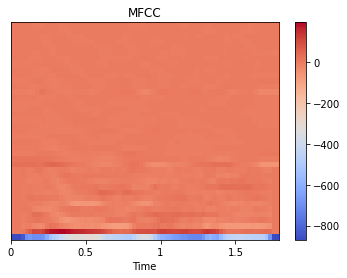

In [14]:
fig, ax = plt.subplots()
img = librosa.display.specshow(features[1][0], x_axis='time', ax=ax)
fig.colorbar(img, ax=ax)
ax.set(title='MFCC')

[Text(0.5, 1.0, 'MFCC')]

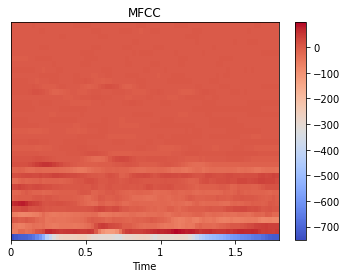

In [15]:
fig, ax = plt.subplots()
img = librosa.display.specshow(features[10][0], x_axis='time', ax=ax)
fig.colorbar(img, ax=ax)
ax.set(title='MFCC')

## Training the model

In [16]:
X = list()
y = list()
svd = TruncatedSVD(n_components=50, n_iter=7, random_state=42)

In [17]:
for label in labels:
    for i in range(len(features[label]) - 1):
        truncated_features = svd.fit_transform(features[label][0]).ravel()
        X.append(truncated_features)
        y.append(label)

In [18]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X, y)

KNeighborsClassifier(n_neighbors=3)

In [19]:
correct_pred = 0
for label in labels:
    truncated_features = svd.fit_transform(features[label][9]).ravel()
    prediction = knn.predict([truncated_features])
    print("The predicted label is: [{}] while the correct label is: {}".format(label, prediction))
    correct_pred = correct_pred + 1 if label == prediction else correct_pred
print("The correct predictions percentage = {}%".format((correct_pred/10)*100))

The predicted label is: [1] while the correct label is: [6]
The predicted label is: [2] while the correct label is: [6]
The predicted label is: [3] while the correct label is: [1]
The predicted label is: [4] while the correct label is: [1]
The predicted label is: [5] while the correct label is: [5]
The predicted label is: [6] while the correct label is: [3]
The predicted label is: [7] while the correct label is: [4]
The predicted label is: [8] while the correct label is: [10]
The predicted label is: [9] while the correct label is: [4]
The predicted label is: [10] while the correct label is: [10]
The correct predictions percentage = 20.0%
